# 预训练BERT

In [37]:
import torch
from torch import nn
from d2l import torch as d2l
import os 
import random

In [38]:
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
def _read_wiki(data_dir):
    '''
    1. 构建文件路径
    data_dir：数据目录路径
    wiki.train.tokens：WikiText格式的训练文件
    文件格式：纯文本，每行是一个段落，句子用 .（空格+句点+空格）分隔
    '''

    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    '''
    2. 读取文件
    读取所有行：每行是一个段落字符串
    lines：列表，每个元素是一个字符串（包含换行符）
    '''
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    '''
    3. 处理段落
    步骤1：line.strip()：移除行首尾的空白字符和换行符
    步骤2：.lower()：大写转小写：统一文本格式，减少词汇表大小
    例："Hello World . This is BERT." → "hello world . this is bert."
    步骤3：.split(' . ')：按句子分隔符分割，使用' . '（空格+句点+空格）作为分隔符，结果得到一个句子列表
    例："hello world . this is bert ." → ['hello world', 'this is bert', '']
    步骤4：if len(...)>=2，筛选有效段落 ：只保留至少包含2个句子的段落，目的：为NSP任务准备（需要句对）
    '''
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    '''
    4. 随机打乱
    作用：随机打乱段落顺序
    目的：确保训练数据分布均匀，避免模型记住顺序
    '''
    random.shuffle(paragraphs)
    # 返回结果：paragraphs列表，每个元素是句子列表
    return paragraphs

In [39]:
'''
sentence：当前句子A（字符串）
next_sentence：句子A的真实下一句（正例）
paragraphs：所有段落的列表（三重嵌套结构）
'''
#@save
def _get_next_sentence(sentence, next_sentence, paragraphs):
    # 50%概率生成正例
    if random.random() < 0.5: # 生成[0,1)之间的随机数，以50%概率保持真实下一句
        is_next = True # 标签为正（是下一句
    else:
        # 50%概率生成负例
        # paragraphs是三重列表的嵌套
        next_sentence = random.choice(random.choice(paragraphs)) # 随机选择一个段落（二级列表），再在该段落中随机选择一个句子
        is_next = False # 标签为负（不是下一句）
    return sentence, next_sentence, is_next # next_sentence是真实的

In [40]:
'''
以50%概率生成正例（真实下一句）
以50%概率生成负例（随机段落中的随机句子）
检查长度约束并转换为BERT输入格式
'''
#@save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    # 1. 初始化结果列表：存储当前段落生成的所有NSP训练样本
    nsp_data_from_paragraph = []
    '''
    2. 遍历段落中的句子
        遍历索引0到len(paragraph)-1
        原因：需要取paragraph[i]和paragraph[i+1]组成句对
    '''
    for i in range(len(paragraph) - 1):
        '''
        3. 生成正例/负例
        paragraph[i]：当前句子A（字符串）
        paragraph[i+1]：句子A的真实下一句B（字符串）
        paragraphs：所有段落的嵌套列表（用于负例采样）
        返回：
            tokens_a：句子A的词元列表
            tokens_b：句子B的词元列表（可能是真实下一句，也可能是随机句子）
            is_next：布尔值，True表示是真实下一句，False表示随机句子
        '''
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        '''
        4. 长度检查与过滤
        +3的含义：
            '<cls>'：1个特殊词元（序列开头）
            '<sep>'：2个特殊词元（句子A结尾、句子B结尾）
        max_len：最大序列长度限制（如512）
        continue：如果超长，跳过该句对，不加入训练集
        '''
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        '''
        5. 转换为BERT输入格式
            tokens：合并后的词元列表（格式：<cls>+tokens_a+<sep>+tokens_b+<sep>）
            segments：段标记列表（0表示句子A，1表示句子B）
        '''
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        '''
        6. 存储样本
        tokens：输入词元序列
        segments：片段标记
        is_next：标签（True/False）
        '''
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    # 7. 返回所有样本：返回值：列表，每个元素是一个(tokens,segments,is_next)元组
    return nsp_data_from_paragraph

In [41]:
'''
tokens:BERT输入序列的词元列表（如['<cls>','我','爱','深','度','学','习','<sep>']）
candidate_pred_positions:可能被遮蔽的词元位置索引列表（特殊词元如<cls>、<sep>会被排除）
num_mlm_preds:需要预测的词元数量（通常是序列长度的15%）
vocab:词表对象，用于随机选择替换词元
'''
#@save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的“<mask>”或随机词元
    '''
    1. 创建输入词元副本
    目的：创建可修改的副本，不破坏原始序列
    深拷贝：列表推导式确保修改副本不影响原始tokens
    '''
    mlm_input_tokens = [token for token in tokens]
    '''
    2. 初始化预测位置和标签列表
    pred_positions_and_labels：存储预测位置和对应的真实词元
    用途：存储被替换位置及其原始词元的元组
    格式：[(位置1,原始词1),(位置2,原始词2),...]
    '''
    pred_positions_and_labels = []
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    '''
    3. 打乱候选预测位置
    原因：确保随机性，模型无法预测哪些位置会被掩蔽
    candidate_pred_positions：所有可被掩蔽的位置索引列表（通常排除<cls>和<sep>）
    '''
    random.shuffle(candidate_pred_positions)
    '''
    4. 遍历并选择预测位置
    终止条件：达到预设的掩蔽数量（通常为序列长度的15%）
    提前退出：避免掩蔽过多词元
    '''
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        '''
        5. 80-10-10替换策略（核心）
        这是BERT MLM任务的关键设计，对每个候选位置：
        (1) 80%的时间：将词替换为“<mask>”词元
            主要任务：模型必须预测原始词元
            训练目标：学习双向上下文理解
        '''
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            '''
            (2) 10%的时间：保持词不变
                目的：减少训练和推理差异（推理时没有<mask>）
                信号：模型看到原始词元，但仍需预测它（有点矛盾，但有效）
            '''
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            else:
                '''
                (3) 10%概率替换为随机词
                    目的：强制模型不完全依赖<mask>，必须理解上下文
                    噪声引入：随机词提供干扰，防止模型"偷懒"
                '''
                masked_token = random.choice(vocab.idx_to_token)
        '''
        6. 执行替换并记录 
        替换操作：将词元放入副本的指定位置
        记录标签：保存原始位置和原始词元，用于后续损失计算
        '''
        mlm_input_tokens[mlm_pred_position] = masked_token
        '''
        作用：将被遮蔽的位置和该位置的原始词元组成元组，存入列表
        为什么用tokens而不是mlm_input_tokens？
            tokens[mlm_pred_position]：原始词元（如'学习'），作为预测目标（label）
            mlm_input_tokens[mlm_pred_position]：已被替换为<mask>或随机词，不再是正确答案
        数据结构：[(pos1,label1),(pos2,label2),...]，确保位置与标签一一对应
        '''
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    '''
    返回值1：mlm_input_tokens-替换后的词元序列（用于模型输入）
    返回值2：pred_positions_and_labels-被遮蔽位置和原始词元的配对列表（用于计算损失）
    '''
    return mlm_input_tokens, pred_positions_and_labels

In [42]:
#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    # 1. 初始化候选位置列表：用于存储所有可以被遮蔽的词元位置索引
    candidate_pred_positions = []
    # tokens是一个字符串列表
    '''
    2. 遍历词元序列，排除特殊词元
    关键逻辑：特殊词元（<cls>分类标记、<sep>分隔标记）不参与预测
    原因：这些词元是BERT输入的结构标记，不是语义内容
    结果：candidate_pred_positions=[1,2,3,4]（假设tokens长度为5）
    '''
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    '''
    3. 计算需要预测的词元数量
    遮蔽语言模型任务中预测15%的随机词元
    规则：至少预测1个词元（即使序列很短）
    比例：15%的词元会被选中
    示例：若len(tokens)=20，则num_mlm_preds=3
    max(1,...)的作用：防止序列过短时计算结果为0
    '''
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    '''
    4. 执行遮蔽替换
    调用下层函数：传入原始词元、候选位置、预测数量和词表
    返回结果：
    mlm_input_tokens：已遮蔽的词元序列（如['<cls>','我','<mask>','NLP','<sep>']）
    pred_positions_and_labels：被遮蔽位置和原始词元的配对列表，如[(2,'爱')]
    '''
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    '''
    5. 按位置排序（关键步骤）
    作用：确保预测位置按升序排列
    为什么需要排序？
        _replace_mlm_tokens中random.shuffle()打乱了选择顺序
        模型需要固定顺序来处理预测位置
        后续分离位置/标签时保证一一对应关系不混乱
    '''
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    # 分离位置和标签：将元组列表拆分为两个独立列表
    pred_positions = [v[0] for v in pred_positions_and_labels] # 提取位置
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels] # 提取原始词元
    '''
    返回最终数据
    返回值1：vocab[mlm_input_tokens]-输入词元的ID序列
        通过词表将词元转换为整数ID（如[101,2769,103,1920,102]）
    返回值2：pred_positions-被遮蔽位置的索引列表
    返回值3：vocab[mlm_pred_labels]-预测目标的ID列表
    '''
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [43]:
'''
_pad_bert_inputs将多个样本（每个样本长度不同）填充到固定的max_len，并返回7个列表，分别对应：
    token序列、段落标记、有效长度
    预测位置、预测权重、预测标签
    NSP标签
'''
#@save
def _pad_bert_inputs(examples, max_len, vocab):
    '''
    作用：计算每个样本最多需要预测多少词元（15%的max_len）
    示例：若max_len=128，则max_num_mlm_preds=19
    '''
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        # 1.  填充token序列：在序列末尾添加<pad>词元，直到长度达到max_len
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long)) # 差值
        # 2. 填充段落标记：段落标记也填充为0（与pad保持一致），这里的0表示"属于段落A"，填充部分也属于A
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # 3. 记录有效长度（不含pad）：记录原始序列的真实长度（不包括填充部分）
        # 示例：len(token_ids)=5，有效长度就是5
        # 用途：在Transformer的Attention计算中，用valid_len屏蔽pad位置
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        # 4. 填充预测位置：预测位置列表也填充到固定长度max_num_mlm_preds
        # 填充值：用0填充（0是有效位置，但后面用权重屏蔽）
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        '''
        5. 设计预测权重
        作用：区分真实预测位置和填充位置
        机制：
            真实预测位置→权重为1.0（参与损失计算）
            填充位置→权重为0.0（在损失中被屏蔽）
        实现：在计算损失时，loss*weight，填充位置的loss被置0
        '''
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        # 6. 填充预测标签：标签也填充为0（配合权重为0，不会影响损失）
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        # 7. 收集NSP标签：收集"是否为下一句"的二分类标签（0或1）
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [44]:
#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    '''
    paragraphs:原始段落列表，每个元素是字符串（如["I love NLP. It's fun.","Deep learning rocks!"]）
    max_len:最大序列长度（如128、512）
    '''
    def __init__(self, paragraphs, max_len):
        # 输入paragraphs[i]是代表段落的句子字符串列表；
        # 而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        # 1.  词元化（Tokenization）：将每个段落字符串拆分为句子列表，再将每个句子拆分为词元列表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        '''
        2. 构建词汇表
        双重列表推导式：将所有段落的所有句子展平为一个句子列表
        min_freq=5：只保留出现≥5次的词（过滤低频词）
        reserved_tokens：强制添加的特殊词元：
            <pad>：填充标记
            <mask>：遮蔽标记
            <cls>：分类标记（句首）
            <sep>：分隔标记（句间）
        '''
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        '''
        3. 生成NSP（下一句预测）数据
        调用函数：_get_nsp_data_from_paragraph为每个段落生成NSP样本
        样本格式：每个样本是 (tokens,segments,is_next)
            tokens：词元ID列表（如[<cls>,句子A,<sep>,句子B,<sep>]）
            segments：段落标记（0/1，区分句子A/B）
            is_next：二分类标签（1=是下一句，0=不是）
        作用：构建BERT的第一个预训练任务数据
        '''
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        '''
        4. 生成MLM（遮蔽语言模型）数据
        操作：对每个NSP样本，生成MLM遮蔽数据
        _get_mlm_data_from_tokens 返回：(mlm_input_tokens,pred_positions,mlm_pred_labels)
        元组拼接：将MLM数据与NSP数据合并
        最终格式：(tokens,pred_positions,mlm_labels,segments,is_next)
        '''
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # 填充输入
        '''
        5. 填充并存储数据
        调用 _pad_bert_inputs：将所有样本填充到max_len长度
        解压赋值：将返回的7个列表分别赋值给类的属性
        最终属性：
            self.all_token_ids：输入词元ID序列（填充后）
            self.all_segments：段落标记（填充后）
            self.valid_lens：有效长度（不含填充）
            self.all_pred_positions：预测位置（填充后）
            self.all_mlm_weights：预测权重（1.0/0.0屏蔽填充）
            self.all_mlm_labels：预测标签（填充后）
            self.nsp_labels：NSP二分类标签
        '''
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab) # 元组解包赋值
    '''
    功能：通过索引idx获取单个训练样本
    调用方式：dataset[i]等价于dataset.__getitem__(i)
    返回：包含7个张量的元组，对应一个BERT训练样本
    '''
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])
    '''
    作用：返回数据集中有多少个训练样本
    原理：self.all_token_ids是一个列表，每个元素对应一个样本，所以它的长度就是样本总数
    '''
    def __len__(self):
        return len(self.all_token_ids)

In [45]:
'''
作用：加载WikiText-2语料库，返回可迭代的数据加载器和词表
batch_size：每个批次的样本数量（如256、512）
max_len：序列最大长度（如128、512）
'''

#@save
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    '''
    1. 设置数据加载工作进程
    作用：获取CPU核心数，用于并行数据加载
    示例：8核CPU→num_workers=4（留出核心给主进程）
    目的：加速数据预处理，避免GPU等待数据
    '''
    num_workers = 0
    '''
    2. 下载并解压数据集
    行为：自动从网络下载WikiText-2数据集并解压
    WikiText-2是什么：包含维基百科文章的中等规模语料库（训练集约36MB）
    返回：解压后的文件夹路径
    '''
    data_dir = '..\\data\\wikitext-2'
    '''
    3. 读取原始文本
    调用_read_wiki：读取所有文本文件，按段落组织
    返回格式：paragraphs[i]是第i个段落的原始字符串
    '''
    paragraphs = _read_wiki(data_dir)
    '''
    4.  创建数据集实例
    调用__init__：执行我们之前解析的完整数据处理流水线
    耗时操作：词表构建、NSP/MLM样本生成、填充处理（可能耗时数分钟）
    结果：train_set包含所有预处理后的数据（数百万样本）
    '''
    train_set = _WikiTextDataset(paragraphs, max_len)
    '''
    5. 创建数据迭代器
    作用：将数据集包装为可迭代对象，支持批量加载
    关键参数：
    shuffle=True：每个epoch打乱样本顺序，防止模型学到顺序偏见
    num_workers=num_workers：多进程并行加载数据
    返回：train_iter是PyTorch的DataLoader对象
    '''
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    '''
    6. 返回结果
    返回值1：train_iter-数据加载器，训练时循环迭代
    返回值2：train_set.vocab-词表，用于词元↔ID转换
    '''
    return train_iter, train_set.vocab

首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。批量大小是512，BERT输入序列的最大长度是64。注意，在原始BERT模型中，最大长度是512。


In [46]:
'''
批次大小：512个样本/批次（适合GPU内存）
序列长度：每个样本最多64个词元（含<cls>、<sep>、填充）
'''
batch_size, max_len = 512, 64
'''
train_iter：PyTorch DataLoader对象，可迭代
    每次迭代返回7个张量的元组（见上一问的print输出）
    自动处理打乱（shuffle）和多进程加载
vocab：Vocab对象
    词元↔ID的双向映射
    len(vocab)查看词表大小（通常~2万）
    vocab['<mask>']获取特殊词元ID
'''
train_iter, vocab = load_data_wiki(batch_size, max_len)

## 预训练BERT

原始BERT`Devlin.Chang.Lee.ea.2018`有两个不同模型尺寸的版本。基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。


| 参数                    | 值   | 含义                       |
| --------------------- | --- | ------------------------ |
| `len(vocab)`          | ~2万 | 词汇表大小（动态获取）              |
| `num_hiddens=128`     | 128 | **隐藏层维度**（原始BERT是768）    |
| `norm_shape=[128]`    | 128 | LayerNorm的归一化维度          |
| `ffn_num_input=128`   | 128 | FFN输入维度（通常=num\_hiddens） |
| `ffn_num_hiddens=256` | 256 | **FFN中间层维度**（原始是3072）    |
| `num_heads=2`         | 2   | **注意力头数**（原始是12）         |
| `num_layers=2`        | 2   | **Transformer层数**（原始是12） |
| `dropout=0.2`         | 0.2 | Dropout比率（原始是0.1）        |
| `key_size=128`        | 128 | 注意力键维度（通常=num\_hiddens）  |
| `query_size=128`      | 128 | 注意力查询维度                  |
| `value_size=128`      | 128 | 注意力值维度                   |
| `hid_in_features=128` | 128 | NSP分类器输入维度               |
| `mlm_in_features=128` | 128 | MLM预测头输入维度               |
| `nsp_in_features=128` | 128 | NSP预测头输入维度               |


In [47]:
'''
对比：原始BERT-base
num_hiddens=768      # 这里是128（缩小6倍）
ffn_num_hiddens=3072 # 这里是256（缩小12倍）
num_heads=12         # 这里是2（缩小6倍）
num_layers=12        # 这里是2（缩小6倍）
'''
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
'''
设备配置
作用：获取所有可用的GPU列表
返回值：
    单GPU：[device(type='cuda',index=0)]
    多GPU：[device('cuda:0'),device('cuda:1'),...]
    无GPU：[device(type='cpu')]
'''
devices = d2l.try_all_gpus()
'''
损失函数定义
BERT预训练同时计算两个损失：
    MLM损失：预测被遮蔽的词元
    NSP损失：判断是否为下一句
'''
loss = nn.CrossEntropyLoss()

在定义训练代码实现之前，我们定义了一个辅助函数`_get_batch_loss_bert`。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。


| 参数                         | 形状示例        | 含义                 |
| -------------------------- | ----------- | ------------------ |
| `tokens_X`                 | `[512, 64]` | 批次词元ID（512样本×64长度） |
| `segments_X`               | `[512, 64]` | 0/1标记，区分句子A/B      |
| `valid_lens_x.reshape(-1)` | `[512]`     | 每个样本的真实长度（不含pad）   |
| `pred_positions_X`         | `[512, 9]`  | MLM任务中需要预测的位置索引    |

<BR>

| 返回值         | 形状示例                   | 含义                            |
| ----------- | ---------------------- | ----------------------------- |
| `_`（忽略）     | `[512, 64, 128]`       |  编码后的序列表示 （后续任务不需要）   |
| `mlm_Y_hat` | `[512, 9, vocab_size]` |  MLM预测 ：每个预测位置的词表概率   |
| `nsp_Y_hat` | `[512, 2]`             |  NSP预测 ：二分类概率（是/否下一句） |


**完整数据流示例**

```Python
# 输入数据（一个批次）
tokens_X = torch.tensor([[101, 1920, 103, 6207, 102, 0, 0, 0],
                         [101, 2603, 4263, 103, 102, 0, 0, 0]])  # [2, 8]
segments_X = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0]])  # [2, 8]
valid_lens_x = torch.tensor([5, 5])  # [2]
pred_positions_X = torch.tensor([[2, 0], [3, 0]])  # [2, 2]

# 前向传播
_, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x, pred_positions_X)

# 输出
# mlm_Y_hat.shape = [2, 2, vocab_size]  
#   → 2个样本，每个2个预测位置，每个位置vocab_size个概率

# nsp_Y_hat.shape = [2, 2]
#   → 2个样本，每个2个类别（是/否下一句）
```
**为什么不用编码输出？**

```Python
# 编码输出用于微调（Fine-tuning）
encoded_X, mlm_Y_hat, nsp_Y_hat = net(...)

# 示例：文本分类微调
cls_output = encoded_X[:, 0, :]  # 取<cls>位置的表示
logits = classifier(cls_output)   # 接一个分类头
在预训练阶段：我们只关注MLM和NSP的损失，不需要主输出。
```

| 参数                 | 类型                    | 形状示例        | 含义                  |
| ------------------ | --------------------- | ----------- | ------------------- |
| `net`              | `nn.Module`           | -           | BERT模型实例            |
| `loss`             | `nn.CrossEntropyLoss` | -           | 损失函数对象              |
| `vocab_size`       | `int`                 | 约2万         | 词汇表大小（用于reshape）    |
| `tokens_X`         | `Tensor`              | `[512, 64]` | 批次词元ID              |
| `segments_X`       | `Tensor`              | `[512, 64]` | 段落标记（0/1）           |
| `valid_lens_x`     | `Tensor`              | `[512]`     | 有效长度（不含pad）         |
| `pred_positions_X` | `Tensor`              | `[512, 9]`  | MLM预测位置             |
| `mlm_weights_X`    | `Tensor`              | `[512, 9]`  | **权重（1.0/0.0屏蔽填充）** |
| `mlm_Y`            | `Tensor`              | `[512, 9]`  | **MLM真实标签**         |
| `nsp_y`            | `Tensor`              | `[512]`     | **NSP真实标签**（0/1）    |


In [48]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    '''
    关键：valid_lens_x.reshape(-1)
        原始形状：[512,1]或[512]
        reshape(-1)→[512]（确保是一维）
        作用：告诉Transformer哪些位置是有效词元（用于Attention屏蔽pad）
     为什么用_忽略第一个返回值？
        BERT模型返回3个值：
            encoded_X：所有词元的上下文表示（用于微调）
            mlm_Y_hat：遮蔽词预测（当前任务需要）
            nsp_Y_hat：下一句预测（当前任务需要）
            在预训练阶段，我们只关心后两个（MLM和NSP损失），所以用_忽略主输出
    '''

    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, # 输入词元ID
                                  segments_X, # 输入词元ID
                                  valid_lens_x.reshape(-1), # 有效长度（reshape是为了适配API）
                                  pred_positions_X) # 需要预测的位置
    '''
    计算遮蔽语言模型损失
    模型返回：编码输出（忽略）、MLM预测（[batch,max_pred,vocab_size]）、NSP预测（[batch,2]）
    MLM损失计算
    形状变换：
        mlm_Y_hat：从[32,9,vocab_size]→[288,vocab_size]（288=32×9）
        mlm_Y：从[32,9]→[288]
        mlm_weights_X：从[32,9]→[288,1]（用于广播）
    关键点：乘以mlm_weights_X
        真实预测位置：权重=1.0，损失保留
        填充位置：权重=0.0，损失被屏蔽
    '''
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    '''
    MLM损失平均
    为什么这样平均？：只计算真实预测位置的平均损失
        mlm_weights_X.sum()：统计真实预测数量（如18.0）
        1e-8：防止除零（极端情况：batch中无预测位置）
    '''
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    '''
    计算下一句子预测任务的损失
    NSP损失计算
    二分类任务：nsp_Y_hat形状 [batch,2]，nsp_y形状[batch]
    直接计算：无填充问题，无需权重
    '''
    nsp_l = loss(nsp_Y_hat, nsp_y)
    # 总损失：直接相加：两个任务同等重要（原始BERT设计）；返回值：用于反向传播
    l = mlm_l + nsp_l
    '''
    返回结果
    三个标量损失值，用于监控训练过程：
        mlm_l：MLM任务损失
        nsp_l：NSP任务损失
        l：总损失
    '''
    return mlm_l, nsp_l, l

通过调用上述两个辅助函数，下面的`train_bert`函数定义了在WikiText-2（`train_iter`）数据集上预训练BERT（`net`）的过程。训练BERT可能需要很长时间。以下函数的输入`num_steps`指定了训练的迭代步数，而不是像`train_ch13`函数那样指定训练的轮数。


| 参数名          | 类型                    | 示例值                     | 含义                        |
| ------------ | --------------------- | ----------------------- | ------------------------- |
| `train_iter` | `DataLoader`          | `train_iter`            | **训练数据迭代器**（批量加载数据）       |
| `net`        | `nn.Module`           | `BERTModel(...)`        | **BERT模型实例**              |
| `loss`       | `nn.CrossEntropyLoss` | `nn.CrossEntropyLoss()` | **损失函数**（MLM和NSP共用）       |
| `vocab_size` | `int`                 | `len(vocab)` ≈ 17964    | **词汇表大小**（用于MLM输出reshape） |
| `devices`    | `List[torch.device]`  | `[cuda:0, cuda:1]`      | **GPU设备列表**（用于并行训练）       |
| `num_steps`  | `int`                 | `1000`                  | **总训练步数**（BERT原始论文用100万步） |


**Q: 为什么不用 for epoch in range(num_epochs)？**

A: BERT预训练通常按步数（100万步）而非epoch，确保数据遍历的随机性。

**Q: metric[0] / metric[3] 是什么？**

A: metric[0]是MLM损失总和，metric[3]是步数，相除得平均每步MLM损失。

**Q: timer.stop() 在循环内还是外？**

A: 在循环内，但d2l.Timer会自动累积时间，最终timer.sum()返回总时间。

| 循环          | 作用          | 终止条件                            |
| ----------- | ----------- | ------------------------------- |
| **`while`** | 控制**总训练步数** | `step == num_steps`             |
| **`for`**   | 遍历**数据集批次** | 数据集遍历完或`num_steps_reached=True` |


**Metric累积器**
```python
metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
#         ↑      ↑      ↑                ↑
#         |      |      |                └─ 步数计数（用于平均）
#         |      |      └─ 样本数（用于计算速度）
#         |      └─ NSP损失总和
#         └─ MLM损失总和
```
**计算方式：**

- metric[0] / metric[3] = MLM平均损失
- metric[1] / metric[3] = NSP平均损失
- metric[2] / timer.sum() = 每秒处理样本数

**完整时序图**
```Python
step = 0
↓
while step < 1000:
    ↓
    for batch in train_iter:  # 遍历数据集
        ↓
        # 处理一个批次
        step = 1 → 更新 → animator → step = 2
        step = 2 → 更新 → animator → step = 3
        ...
        step = 1000 → num_steps_reached = True → break
        ↓
    break  # 退出while循环
    ↓
打印最终损失和速度
```

In [49]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    '''
    1. 模型并行化
    作用  ：将模型复制到所有可用的GPU上，实现数据并行训练
    原理  ：每个GPU处理一部分batch数据，梯度自动汇总
    设备0：作为主GPU，负责参数更新
    '''
    num_workers = 0
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    '''
    2. 优化器设置
    Adam优化器：自适应学习率，适合BERT这类大规模模型
    lr=0.01：初始学习率（实际训练会配合warmup策略）
    自动更新：反向传播后调用trainer.step()更新参数
    '''
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    '''
    3. 计时器与可视化
    step：记录已训练的步数
    timer：计时器，计算每秒处理多少样本
    animator：实时绘制损失曲线（动态更新）
    '''
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    '''
    4. 累积器
    4个槽位分别累积：
        mlm_l：MLM损失总和
        nsp_l：NSP损失总和
        tokens_X.shape[0]：样本数量（用于计算速度）
        1：步数计数（用于平均）

    '''
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    # 5. 主训练循环
    while step < num_steps and not num_steps_reached:
        # 数据加载
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter: # 遍历所有批次
            # 数据移动到GPU
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            # 梯度清零
            trainer.zero_grad()
            timer.start()
            # 前向传播 + 计算损失
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            # 反向传播
            l.backward()
            # 更新参数
            trainer.step()
            # 累积统计
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            '''
            每步更新可视化
            实时绘图：X轴=step，Y轴=loss
            双曲线：显示MLM和NSP损失
            平滑：使用累积平均值，避免单步抖动
            '''
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            # 训练终止条件
            if step == num_steps:
                num_steps_reached = True
                break
    '''
    最终输出
        平均损失：MLM和NSP的每步平均损失
        训练速度：每秒处理多少句子对（衡量GPU利用率）
        设备信息：显示使用的GPU列表（如[cuda:0, cuda:1]）
    '''
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。


MLM loss 5.569, NSP loss 0.727
5854.1 sentence pairs/sec on [device(type='cuda', index=0)]


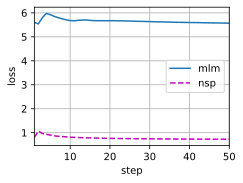

In [51]:
train_bert(train_iter, # train_iter=数据加载器：提供批次数据
           net, # net=模型：接收数据并预测
           loss, # loss=损失函数：计算预测与真实的差距
           len(vocab), # vocab_size=词表大小：用于MLM的reshape
           devices, # devices=GPU列表：决定并行训练的设备
           50) # num_steps=训练步数：控制训练何时结束

## 用BERT表示文本

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回`tokens_a`和`tokens_b`中所有词元的BERT（`net`）表示。


| 参数         | 类型          | 示例                     | 含义           |
| ---------- | ----------- | ---------------------- | ------------ |
| `net`      | `nn.Module` | 训练好的BERT模型             | **BERT模型实例** |
| `tokens_a` | `List[str]` | `['i', 'love', 'nlp']` | 第一句的词元列表     |
| `tokens_b` | `List[str]` | `['it', 'is', 'fun']`  | 第二句的词元列表（可选） |


In [52]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    '''
    1. 构建BERT输入格式
    功能：将词元转换为BERT标准输入格式
    输出：
        tokens：['<cls>','i','love','nlp','<sep>','it','is','fun','<sep>']
        segments：[0,0,0,0,0,1,1,1,1]
    '''
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    '''
    2. 转换为词元ID（增加batch维度）
    unsqueeze(0)：增加batch维度，从[seq_len]→[1,seq_len]
    devices[0]：移动到主GPU（如cuda:0）
    valid_len：有效长度（告诉模型哪些位置是有效词元，用于Attention屏蔽pad）
    '''
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    '''
    3. 前向传播（只获取编码表示）
    调用方式：不传入pred_positions，表示不需要MLM和NSP预测
    返回：
        encoded_X：最后一层的隐藏状态，形状[1,seq_len,hidden_size]
        _：MLM预测（忽略）
        _：NSP预测（忽略）
    '''
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    '''
    4. 返回编码
    形状：[1,seq_len,num_hiddens]（如[1,9,128]）
    用途：用于下游任务（分类、问答等）
    '''
    return encoded_X

考虑“a crane is flying”这句话。回想一下`subsec_bert_input_rep`中讨论的BERT的输入表示。插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，BERT输入序列的长度为6。因为零是“&lt;cls&gt;”词元，`encoded_text[:, 0, :]`是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。


| 索引 | 词元       | 编码表示                    | 用途            |
| -- | -------- | ----------------------- | ------------- |
| 0  | `<cls>`  | `encoded_text_cls`      | **句子级表示**（分类） |
| 1  | `a`      | `encoded_text[:, 1, :]` | 冠词表示          |
| 2  | `crane`  | `encoded_text_crane`    | **词元表示**（当前词） |
| 3  | `is`     | `encoded_text[:, 3, :]` | 动词表示          |
| 4  | `flying` | `encoded_text[:, 4, :]` | 动词表示          |
| 5  | `<sep>`  | `encoded_text[:, 5, :]` | 分隔符表示         |


| 变量                   | 形状            | 含义                        |
| -------------------- | ------------- | ------------------------- |
| `encoded_text`       | `[1, 6, 128]` | **完整序列编码**（所有词元）          |
| `encoded_text_cls`   | `[1, 128]`    | 句子表示 （<cls>位置）    |
| `encoded_text_crane` | `[1, 128]`    |  词元表示 （"crane"位置） |


**1️⃣ encoded_text.shape**

```Python
encoded_text.shape  # 输出示例: torch.Size([1, 6, 128])
返回：完整编码张量的形状
含义：
1：batch大小（1个句子）
6：词元数量（<cls> a crane is flying <sep>）
128：隐藏层维度（每个词元的向量维度）
```

**2️⃣ encoded_text_cls.shape**

```Python
encoded_text_cls.shape  # 输出示例: torch.Size([1, 128])
返回：<cls> 位置的编码的形状
含义：
1：batch大小
128：句子级表示的维度（用于分类任务）
```

**3️⃣ encoded_text_crane[0][:3]**

```Python
encoded_text_crane[0][:3]  # 输出示例: tensor([ 0.123, -0.456,  0.789])
```
**这是最复杂的双重索引操作：**

**第一步：[0]**

```Python
encoded_text_crane = encoded_text[:, 2, :]  # 形状: [1, 128]
encoded_text_crane[0]  # 形状: [128]（取出batch中第0个样本）
作用：去掉batch维度，得到纯向量
```

**第二步：[:3]**

```Python
encoded_text_crane[0][:3]  # 形状: [3]（取前3个数值）
作用：取出向量的前3个维度（用于快速查看数值）
```

**实际含义**
| 代码                          | 用途       | 相当于查看           |
| --------------------------- | -------- | --------------- |
| `encoded_text.shape`        | **整体结构** | 数据维度是否匹配        |
| `encoded_text_cls.shape`    | **句子表示** | 分类任务的输入维度       |
| `encoded_text_crane[0][:3]` | **具体数值** | 词向量是否合理（有无NAN等） |

<br>

```Python
# 原始张量: [1, 6, 128]
#         ↑   ↑   ↑
#       batch seq dim

encoded_text_cls = encoded_text[:, 0, :]  # [1, 128]（第0个位置）

encoded_text_crane = encoded_text[:, 2, :]  # [1, 128]（第2个位置）

encoded_text_crane[0]  # [128]（去掉batch）

encoded_text_crane[0][:3]  # [3]（只看前3个数值）
```

- .shape：确认张量结构
- [0]：去掉batch维度
- [:3]：快速查看数值范围

```python
encoded_text[:, 2, :]              # [1, 128]  ← 2维张量
            ↓ [0]
encoded_text_crane[0]              # [128]     ← 1维张量
            ↓ [:3]
encoded_text_crane[0][:3]          # [3]       ← 1维张量（更短）
```
- **[0] ：在维度0上取第0个元素 ，结果维度减1**
- 1：是形状的描述，不是数据本身

In [53]:
'''
1.  输入词元
原始句子："a crane is flying"
词元化：拆分为单词列表
后续处理：get_bert_encoding会自动添加<cls>和<sep>
'''
tokens_a = ['a', 'crane', 'is', 'flying']
'''
2.  获取完整编码：将句子输入BERT，返回最后一层隐藏状态
内部变换：
    输入词元→['<cls>','a','crane','is','flying','<sep>']
    序列长度：6
    encoded_text形状：[1,6,hidden_size]（如[1,6,128]）
维度0(batch)：1（1个样本）
维度1(sequence)：6（6个词元位置）
维度2(feature)：128（每个词元的128维向量）
'''
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
'''
3. 提取<cls>
索引：[:,0,:]→取所有batch中第0个位置的向量
对应词元：<cls>（BERT句首的特殊标记）
用途：作为整个句子的语义表示（用于分类任务）
形状：[1,128]（句子向量）
'''
encoded_text_cls = encoded_text[:, 0, :]
'''
4. 提取'crane'位置的编码（词元表示）
索引：[:,2,:]→取第2个位置（从0开始计数）
对应词元：'crane'
用途：获取特定词元的上下文语义（这里是"鹤"的表示）
形状：[1,128]（词元向量）
'''
encoded_text_crane = encoded_text[:, 2, :]
# 打印形状和数值
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([2.0407, 0.2718, 2.4522], device='cuda:0', grad_fn=<SliceBackward0>))

In [54]:
# 创建模拟数据
encoded_text = torch.randn(1, 6, 128)  # [batch, seq, hidden]
encoded_text_crane = encoded_text[:, 2, :]  # [1, 128]

print("原始形状:", encoded_text_crane.shape)  # torch.Size([1, 128])

# 索引操作
result = encoded_text_crane[0]
print("索引后形状:", result.shape)  # torch.Size([128])
print("索引后内容:", result)        # tensor([...128个数值...])

# 再取前3个
final = result[:3]
print("前3个:", final)  # tensor([0.123, -0.456, 0.789])

原始形状: torch.Size([1, 128])
索引后形状: torch.Size([128])
索引后内容: tensor([-0.5885, -1.8327,  1.1131, -1.3741,  0.3516,  0.7546,  0.6277,  0.9405,
        -0.1464,  0.2532,  1.1525,  0.2386, -0.6403, -0.6194, -0.9736,  0.6938,
         0.7303,  0.0992, -0.1656, -2.3645, -1.1288, -0.1972, -0.2952, -0.6164,
        -0.0242, -0.2206,  1.2604,  0.0470,  0.4574, -1.3781, -0.4282,  1.5826,
        -1.6755,  1.7820,  0.4934,  2.6043,  0.6473, -0.8092, -0.4783,  0.8481,
        -1.0425, -1.3514,  1.0731,  1.6297, -0.4732, -0.1220, -0.7563, -0.3926,
         0.5917, -1.1796,  0.5022,  0.7052,  0.4224, -1.5483,  1.3076, -1.9778,
        -0.1583, -0.8052,  0.5081, -1.2020, -0.6026, -0.4723, -0.3457,  0.5757,
        -0.5428, -1.0805,  0.2434,  0.0443,  1.2306, -1.4977, -0.6148,  1.4656,
         0.4356,  0.5436, -0.3598, -1.0490,  0.0063,  0.2937, -0.8904, -1.2022,
        -0.1572, -1.0594, -0.3172,  0.3986,  1.2105,  2.1909,  0.2386, -0.1031,
         0.1857,  3.3664, -0.5066, -0.0348, -0.0569,  1.1733,

现在考虑一个句子“a crane driver came”和“he just left”。类似地，`encoded_pair[:, 0, :]`是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。


| 代码                                           | 位置索引 | 对应词元    | 形状         | 含义                    |
| -------------------------------------------- | ---- | ------- | ---------- | --------------------- |
| `encoded_pair_cls = encoded_pair[:, 0, :]`   | 0    | `<cls>` | `[1, 128]` | **句子对级表示**（用于NSP）     |
| `encoded_pair_crane = encoded_pair[:, 2, :]` | 2    | `crane` | `[1, 128]` | **"起重机"的词元表示**（上下文相关） |


**关键：上下文语义差异**

**对比单句任务：**

**单句 ："a crane is flying" → "crane"指" 鹤**"（鸟）

**句子对 ："a crane driver came" → "crane"指" 起重机**"（机械）

BERT会生成不同的编码向量，体现上下文敏感能力，这是相比Word2Vec的巨大进步。

**位置索引映射**
```Python
Index:    0      1      2       3       4       5      6     7       8      9
Token:  <cls>    a   crane driver   came   <sep>    he   just   left   <sep>
Segment:   0      0      0       0       0       0      1      1       1      1
          └─句子A─────────────────────┘      └─句子B─────────────────┘
[:, 0, :] → <cls>向量（用于NSP分类）
[:, 2, :] → "crane"向量（词义消歧）
[:, 6, :] → "he"向量（第二个句子起始）
```

In [55]:
# 1. 输入数据：任务场景：NSP（下一句预测），判断B是否是A的下一句
# 句子A："一个起重机司机来了"
# 句子B："他刚离开"
tokens_a, tokens_b = ['a','crane','driver','came'],['he','just','left']
'''
2. 获取句子对编码
内部生成的词元序列：['<cls>','a','crane','driver','came','<sep>','he','just','left','<sep>']
编码维度：[1,10,128]
    1：batch大小
    10：总词元数（<cls>+4个A词+<sep>+3个B词+<sep>）
    128：隐藏层维度
'''
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
# 3. 提取表示
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
# 打印结果
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([2.1561, 0.2198, 2.5821], device='cuda:0', grad_fn=<SliceBackward0>))